<a href="https://colab.research.google.com/github/BatoolMM/fastai/blob/master/Fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The First Chapter**

In [1]:
!pip install -Uqq fastbook
!pip install fastcore==1.0.9
!pip install utils
from utils import *
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 8.5MB/s 
     |████████████████████████████████| 61kB 6.2MB/s 
     |████████████████████████████████| 1.0MB 17.4MB/s 
     |████████████████████████████████| 358kB 40.1MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 40kB 3.5MB/s 
     |████████████████████████████████| 40kB 5.3MB/s 
     |████████████████████████████████| 92kB 10.4MB/s 
     |████████████████████████████████| 61kB 8.3MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
     |████████████████████████████████| 2.6MB 44.1MB/s 
  Found existing installation: fastcore 1.0.13
    Uninstalling fastcore-1.0.13:
      Successfully uninstalled fastcore-1.0.13
Mounted at /content/gdrive


In [2]:
from fastbook import *
from fastai.vision.all import *
# !pip install ipywidgets
# import ipywidgets as widgets
# !jupyter nbextension enable --py widgetsnbextension
# !python3 -m pip install --upgrade pip
# !python3 -m pip install --upgrade Pillow

In [ ]:
data = untar_data(URLs.PETS)/'images'

In [ ]:
def is_cat(x):
    return x[0].isupper()

In [ ]:
data_str = ImageDataLoaders.from_name_func(data, 
                                           get_image_files(data),
                                           valid_pct = 0.2, 
                                           seed =42,
                                           label_func = is_cat,
                                           item_tfms = Resize(224))

In [ ]:
model = cnn_learner(data_str, resnet34, metrics=error_rate)
model.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.161170,0.025869,0.008119,00:51


epoch,train_loss,valid_loss,error_rate,time
0,0.057979,0.026976,0.008119,00:55


In [ ]:
image_uploader = widgets.FileUpload()
image_uploader

FileUpload(value={}, description='Upload')

In [ ]:
img = PILImage.create(image_uploader.data[0])

In [ ]:
is_cat, _,prob = model.predict(img)

In [ ]:
print(f"Is this a cat?: {is_cat}.")
print(f"Prob it's a cat: {prob[1].item():6f}")

Is this a cat?: True.
Prob it's a cat: 1.000000


# **The Second Chapter** 

In [3]:
!pip install azure-cognitiveservices-search-imagesearch
import os
from azure.cognitiveservices.search.imagesearch import ImageSearchClient as api
from msrest.authentication import CognitiveServicesCredentials as auth

In [4]:
def search_images_bing(key, term, min_sz=128):
    client = api('https://api.cognitive.microsoft.com', auth(key))
    return L(client.images.search(query=term, count=150, min_height=min_sz, min_width=min_sz).value)
key = '8d86a0d22d7643549e560f18abfe8fde'
key2 ="d5851efce83544c6a29b96a7341f28dd"

In [ ]:
key = '8d86a0d22d7643549e560f18abfe8fde'
key2 ="d5851efce83544c6a29b96a7341f28dd"
Schefflera = search_images_bing(key, "Schefflera")
images_Schefflera = Schefflera.attrgot('content_url')


In [ ]:
len(images_Schefflera)

150

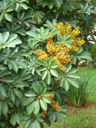

In [ ]:
dest = 'Schefflera.jpg'
download_url(images_Schefflera[0], dest)
img = Image.open(dest)
img.to_thumb(128.128)

In [6]:
plants_type = 'Dieffenbachia', 'Schefflera', 'Dracaena', 'Epipremnum aureum'
path = Path('plants_new')

In [7]:
if not path.exists():
    path.mkdir()
    for o in plants_type:
      dest = (path/o)
      dest.mkdir(exist_ok =True)
      results = search_images_bing(key, f'{o} plant')
      download_images(dest, urls = results.attrgot('content_url'))

In [8]:
files = get_image_files(path)
files

(#592) [Path('plants_new/Epipremnum aureum/00000006.jpg'),Path('plants_new/Epipremnum aureum/00000050.jpg'),Path('plants_new/Epipremnum aureum/00000004.jpg'),Path('plants_new/Epipremnum aureum/00000023.jpg'),Path('plants_new/Epipremnum aureum/00000025.jpg'),Path('plants_new/Epipremnum aureum/00000099.jpg'),Path('plants_new/Epipremnum aureum/00000017.jpg'),Path('plants_new/Epipremnum aureum/00000146.JPG'),Path('plants_new/Epipremnum aureum/00000062.jpg'),Path('plants_new/Epipremnum aureum/00000132.jpg')...]

In [9]:
!ls plants_new

 Dieffenbachia	 Dracaena  'Epipremnum aureum'	 Schefflera


In [10]:
failed = verify_images(files)
failed


(#15) [Path('plants_new/Epipremnum aureum/00000062.jpg'),Path('plants_new/Epipremnum aureum/00000097.jpg'),Path('plants_new/Schefflera/00000132.jpg'),Path('plants_new/Schefflera/00000113.jpg'),Path('plants_new/Schefflera/00000009.jpg'),Path('plants_new/Schefflera/00000020.jpg'),Path('plants_new/Schefflera/00000149.jpg'),Path('plants_new/Dieffenbachia/00000071.jpg'),Path('plants_new/Dieffenbachia/00000145.jpg'),Path('plants_new/Dieffenbachia/00000000.jpg')...]

In [11]:
failed.map(Path.unlink)

(#15) [None,None,None,None,None,None,None,None,None,None...]

In [ ]:
doc(DataBlock)

In [12]:
data = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.1, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))


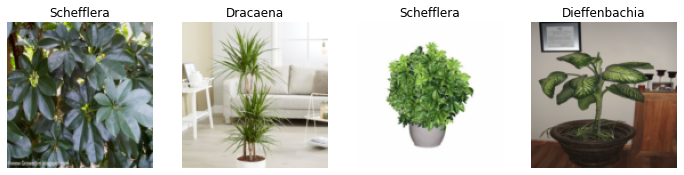

In [19]:
dls = data.dataloaders(path)
dls.valid.show_batch(max_n =4, nrows=1)

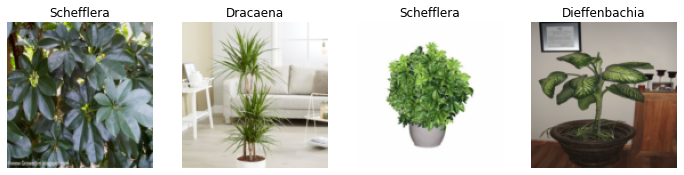

In [20]:
data = data.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = data.dataloaders(path)
dls.valid.show_batch(max_n=4,nrows=1)

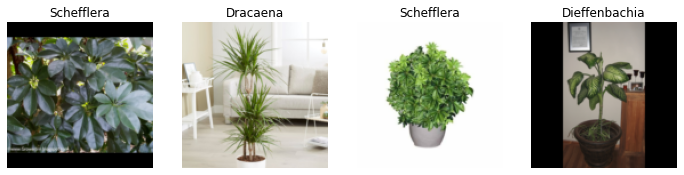

In [22]:
data = data.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = data.dataloaders(path)
dls.valid.show_batch(max_n=4,nrows=1)

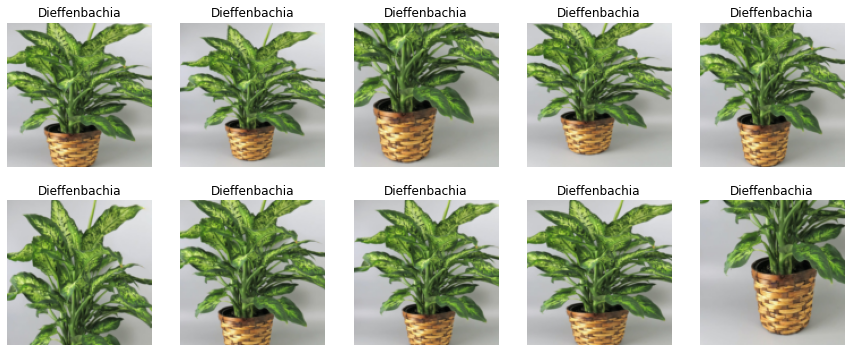

In [38]:
data = data.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = data.dataloaders(path)
dls.train.show_batch(max_n=10, nrows=2, unique=True)

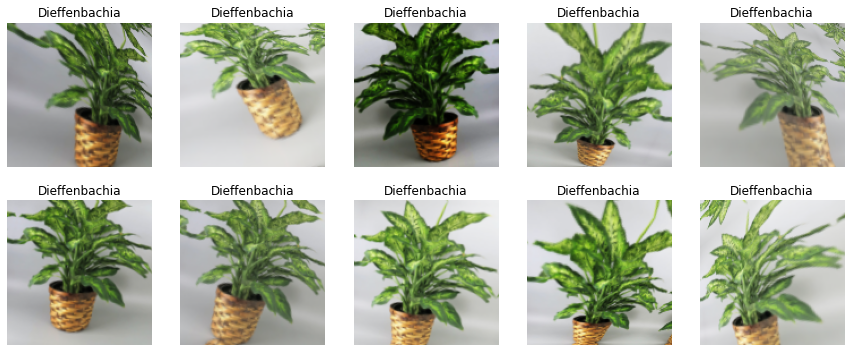

In [39]:
data = data.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = data.dataloaders(path)
dls.train.show_batch(max_n=10, nrows=2, unique=True)

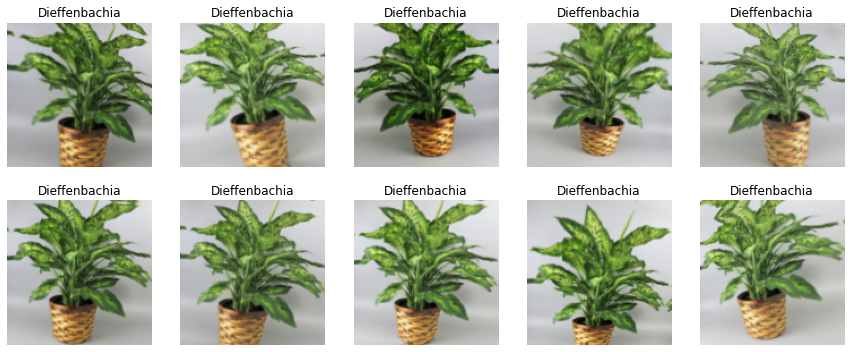

In [40]:
data = data.new(item_tfms=Resize(128), batch_tfms=aug_transforms())
dls = data.dataloaders(path)
dls.train.show_batch(max_n=10, nrows=2, unique=True)

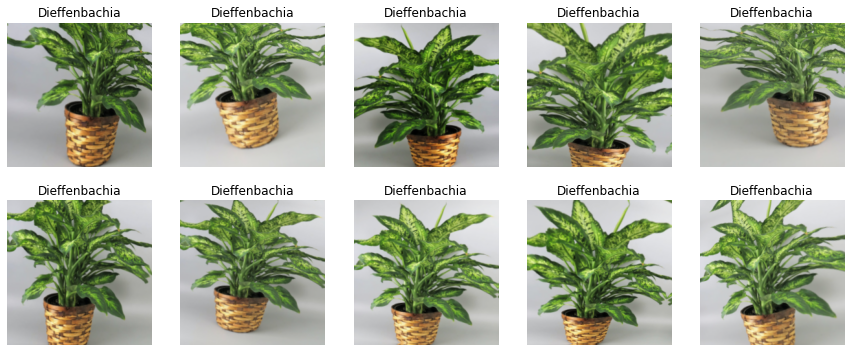

In [47]:
data = data.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = data.dataloaders(path)
dls.train.show_batch(max_n=10, nrows=2, unique=True)

In [50]:
data = data.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())

dls = data.dataloaders(path)
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(5)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.942759,1.187386,0.368421,00:19


epoch,train_loss,valid_loss,error_rate,time
0,0.841913,0.558430,0.245614,00:20
1,0.608242,0.359436,0.157895,00:20
2,0.467363,0.271545,0.105263,00:20
3,0.368432,0.236030,0.105263,00:20
4,0.301577,0.233727,0.087719,00:20


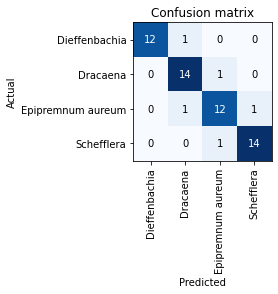

In [51]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

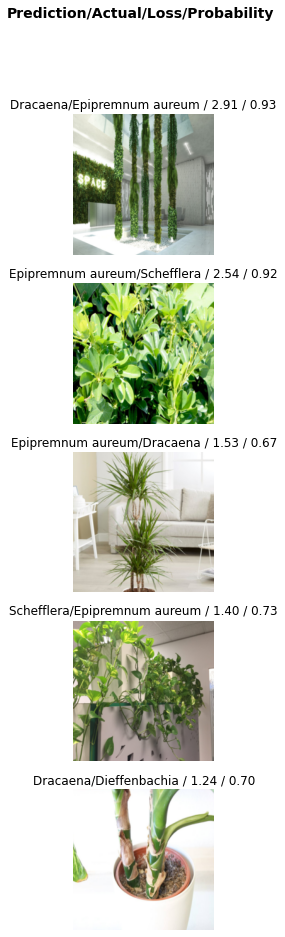

In [52]:
interp.plot_top_losses(5, nrows=5)

In [28]:
data = data.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())

dls = data.dataloaders(path)


In [29]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fit(4)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.374285,0.818848,0.275862,00:18
1,0.942077,0.408650,0.137931,00:19
2,0.732063,0.381484,0.172414,00:18
3,0.606063,0.370996,0.137931,00:18


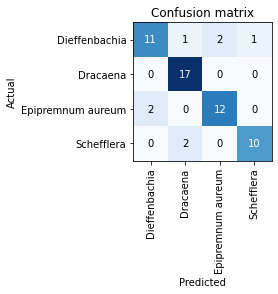

In [30]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
